# Exploratory Data Analysis

In [1]:
# This package will be used for data visualization. It must first be installed then imported. Uncomment to install.
#!pip install handyspark

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
np.bool = np.bool_

In [3]:
from handyspark import *

# Creating the Spark DataFrame iterneraries.csv and doing simple functions

In [4]:
# Url for flight data
url = "gs://my-bigdata-project-mp/landing/itineraries.csv"

# Create a Spark DataFrame from our csv
df = spark.read.csv(url, header=True, inferSchema=True)

In [5]:
# Check the columns and their data types
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: s

In [6]:
# Count how many records are here
num_records = df.count()
print("This dataset contians {} records.".format(num_records))

This dataset contians 82138753 records.


# Using HandySpark to count nulls is all columns

In [7]:
# Create a HandySpark DataFrame from our current DataFrame
hpdf = HandyFrame(df)

/usr/lib/spark/python/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/lib/spark/python/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [8]:
# Count nulls in each column
hpdf.isnull()

24/11/17 00:02:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


legId                                      0
searchDate                                 0
flightDate                                 0
startingAirport                            0
destinationAirport                         0
fareBasisCode                              0
travelDuration                             0
elapsedDays                                0
isBasicEconomy                             0
isRefundable                               0
isNonStop                                  0
baseFare                                   0
totalFare                                  0
seatsRemaining                             0
totalTravelDistance                  6094532
segmentsDepartureTimeEpochSeconds          0
segmentsDepartureTimeRaw                   0
segmentsArrivalTimeEpochSeconds            0
segmentsArrivalTimeRaw                     0
segmentsArrivalAirportCode                 0
segmentsDepartureAirportCode               0
segmentsAirlineName                        0
segmentsAi


# Transform the "travelDuration" column into "travelDurationInMinutes" 

   ###  -   We will do this before the Data visualization step to help up derive infomation about how travel duration affects other variables. 

In [9]:
# We will extract the hour and minutes from travelDuration and combine them into a new column called travelDurationinMinutes

#We will use these functions to extract the numbers from the strings in travelDuration
from pyspark.sql.functions import regexp_extract, col, when, expr


# Define regex patterns to capture hours and minutes
hours_pattern = "PT(\\d+)H"       # Captures the digits before 'H' in the "PT#H" format
minutes_pattern = "H(\\d+)M"       # Captures the digits before 'M' in the "#M" format after 'H'
only_minutes_pattern = "PT(\\d+)M" # For cases with only minutes (e.g., "PT20M")

# Extract hours and minutes, converting to integers
df_extracted = df \
    .withColumn("hours", regexp_extract(col("travelDuration"), hours_pattern, 1).cast("int")) \
    .withColumn("minutes", when(col("travelDuration").rlike(only_minutes_pattern),
                                 regexp_extract(col("travelDuration"), only_minutes_pattern, 1))
                .otherwise(regexp_extract(col("travelDuration"), minutes_pattern, 1)).cast("int"))

# Calculate total minutes
df_with_total_minutes = df_extracted.withColumn(
    "travelDurationinMinutes",
    expr("coalesce(hours, 0) * 60 + coalesce(minutes, 0)")
)

# Get these new columns into our df, then drop the two unnecessary columns
df = df_with_total_minutes

# Compare travelDuration and travelDurationInMinutes to make sure the values are correct
df = df.drop("hours","minutes")
df.select("travelDuration","travelDurationinMinutes").sample(withReplacement=False, fraction=0.05).show(truncate=False)

# Finally, drop travelDuration as it is no longer useful
df = df.drop("travelDuration")

+--------------+-----------------------+
|travelDuration|travelDurationinMinutes|
+--------------+-----------------------+
|PT2H32M       |152                    |
|PT5H45M       |345                    |
|PT9H46M       |586                    |
|PT1H14M       |74                     |
|PT5H6M        |306                    |
|PT3H17M       |197                    |
|PT5H56M       |356                    |
|PT7H28M       |448                    |
|PT11H45M      |705                    |
|PT3H18M       |198                    |
|PT9H56M       |596                    |
|PT2H7M        |127                    |
|PT2H5M        |125                    |
|PT6H56M       |416                    |
|PT6H43M       |403                    |
|PT6H39M       |399                    |
|PT6H50M       |410                    |
|PT7H35M       |455                    |
|PT7H6M        |426                    |
|PT12H22M      |742                    |
+--------------+-----------------------+
only showing top

# Create Pandas DataFrame from a sample and do some data visualization

In [10]:
#Take a sample from our Spark DataFrame and transform it into a Pandas DataFrame. 

sample_percentage = 0.01 # 1% of the dataset represents around 8,200,000 rows. 

sample_spark_df = df.sample(withReplacement=False, fraction=sample_percentage)
pdf = sample_spark_df.toPandas()
pdf.tail(3)

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,elapsedDays,isBasicEconomy,isRefundable,isNonStop,...,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,travelDurationinMinutes
820284,19cc982fdfefe1fb231014aefba49eff,2022-10-05,2022-11-12,DEN,ORD,XAUSA5BC,0,True,False,False,...,2022-11-12T20:45:00.000-06:00||2022-11-12T22:4...,MSP||ORD,DEN||MSP,Delta||Delta,DL||DL,Airbus A321||Airbus A319,6840||5580,693||341,coach||coach,237
820285,ee52ef617bec95f0ef00ced7a659e2a5,2022-10-05,2022-11-12,DEN,PHL,KAVOA0MG,0,False,False,False,...,2022-11-12T10:39:00.000-05:00||2022-11-12T14:4...,ATL||PHL,DEN||ATL,Delta||Delta,DL||DL,Airbus A321||Boeing 757,10440||7020,1207||667,coach||coach,416
820286,9c3e85601a20e2b54d553044da23e483,2022-10-05,2022-11-12,DFW,OAK,OH2OAJM,0,False,False,False,...,2022-11-12T13:10:00.000-08:00||2022-11-12T19:1...,SEA||OAK,DFW||SEA,American Airlines||American Airlines,AA||AA,Airbus A321||Embraer 170,16200||7320,1663||672,coach||coach,630


In [11]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

pdf_numeric = pdf.select_dtypes(include=numerics)
pdf_numeric.head(10)

,elapsedDays,baseFare,totalFare,seatsRemaining,totalTravelDistance,travelDurationinMinutes
0,0,260.47,302.11,1,956.0,257
1,0,262.33,305.61,7,1375.0,356
2,0,171.16,207.60,7,2105.0,550
3,0,254.88,288.60,1,762.0,132
4,0,403.72,457.60,1,762.0,234
5,0,362.22,403.99,4,596.0,115
6,0,204.66,243.61,2,1582.0,370
7,0,256.75,299.61,3,1582.0,423
8,0,533.95,597.60,1,1775.0,372
9,0,243.79,276.67,7,280.0,103


In [12]:
#This function will be used for visualization in the next cell

#Function that looks at a pandas dataframe and checks how much of a column is "distinct".
#Then it creates a ratio of how unique each value is in that column is and creates a new dataframe from that data.
#
#ARG1: Pandas dataframe that you want to check
def distinct_ratio(pandas_df, sort=False):
    
    columns = ["name","distinctCount","totalCount","ratioDistinctTotal"]
    data = []
    
    
    for col_name in pdf.columns:
        distinct = pdf[col_name].nunique()#Number of distinct values in the column
        total = len(pdf[col_name])#Total number of values in the column
        ratio = round(distinct/total, 4) #A numer that is close to 1 is useless for ML. Vice versa for better.
        
        data.append([col_name,distinct,total,ratio])#Append everything we have to data that we will later add to a new dataframe
    
    
    distinct_df = pd.DataFrame(data, columns=columns) #create a new dataframe with our generated data
    distinct_df = distinct_df.set_index(columns[0]) # set "name" as the column
    
    #sorts dataframe by the ratio if requested
    if sort:
        distinct_df.sort_values('ratioDistinctTotal', ascending=False, inplace=True)
    
    return distinct_df

# Visualizing Data

In [ ]:
# Visualization of how "distinct" each column is.

# Essentially shows how useful each column is for ML. A value close to 1 is bad, as more values are unqiue and useless.

#Get distinct data for this graph
distinct_df = distinct_ratio(pdf, sort=True)

#Change size of graph
plt.figure(figsize=(10, 8))

distinct_df["ratioDistinctTotal"].plot(kind="bar", color="orange")

# Add labels and title
plt.title("Ratio of Distinct Values in Each Column")
plt.ylabel("Ratio of Distinctiveness")

# Tilt the x-axis labels
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to prevent label clipping

# Show the graph
plt.show()

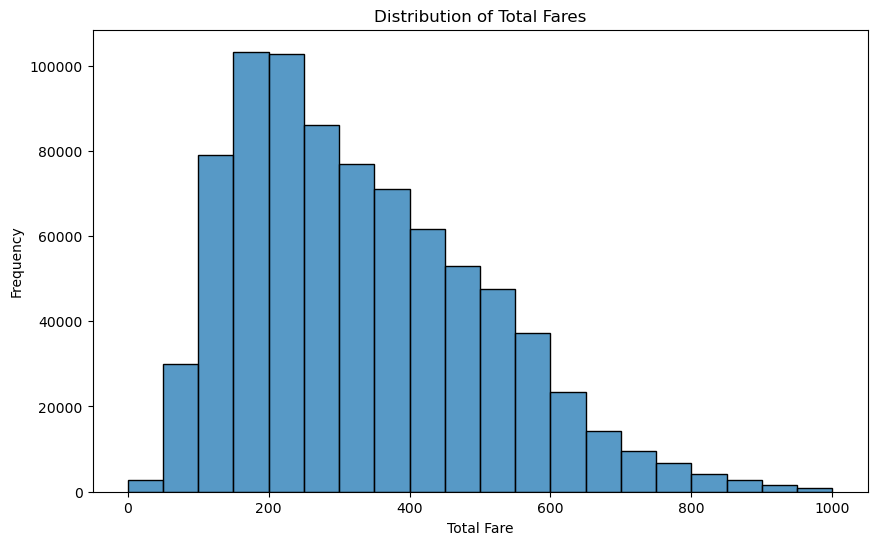

In [14]:
# Fare Distribution

bins = np.arange(0, 1001, 50)

plt.figure(figsize=(10, 6))
sns.histplot(pdf['totalFare'], bins=bins)
plt.title('Distribution of Total Fares')
plt.xlabel('Total Fare')
plt.ylabel('Frequency')
plt.show()

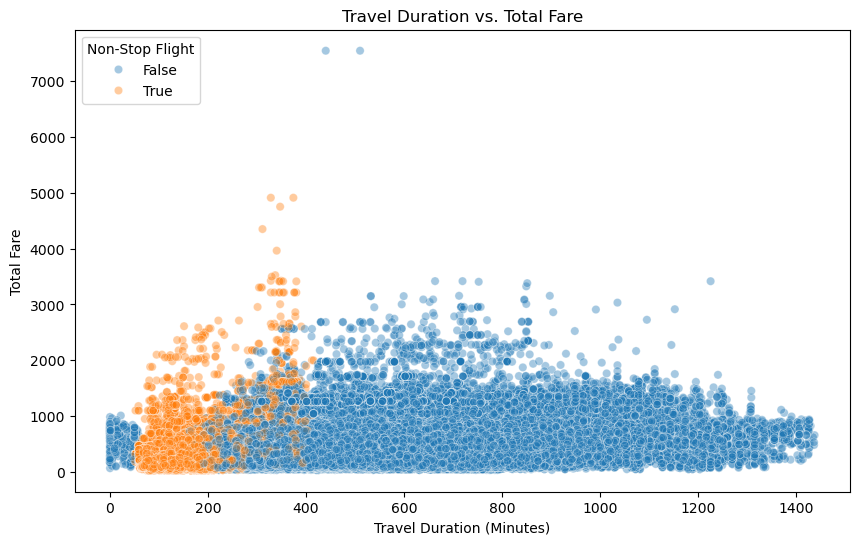

In [15]:
# Travel Duration vs. Total Fare

plt.figure(figsize=(10, 6))
sns.scatterplot(x='travelDurationinMinutes', y='totalFare', data=pdf, hue='isNonStop', alpha=0.4)
plt.title('Travel Duration vs. Total Fare')
plt.xlabel('Travel Duration (Minutes)')
plt.ylabel('Total Fare')
plt.legend(title='Non-Stop Flight', loc='upper left')
plt.show()

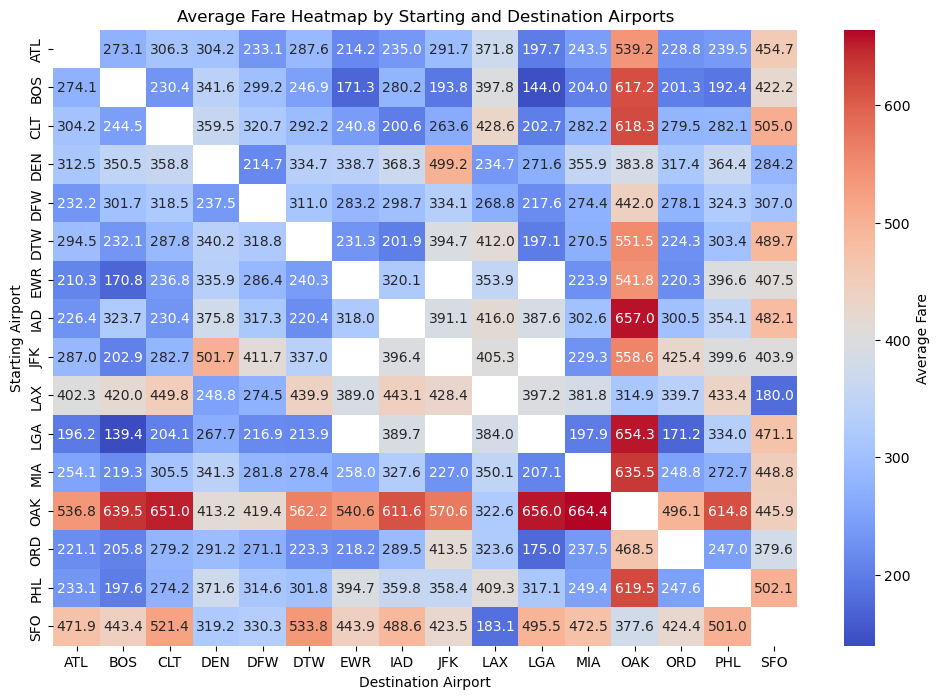

In [16]:
#  Fares by Starting and Destination Airports

fare_matrix = pdf.pivot_table(values='totalFare', index='startingAirport', columns='destinationAirport', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(fare_matrix, annot=True, fmt=".1f", cmap='coolwarm', cbar_kws={'label': 'Average Fare'})
plt.title('Average Fare Heatmap by Starting and Destination Airports')
plt.xlabel('Destination Airport')
plt.ylabel('Starting Airport')
plt.show()

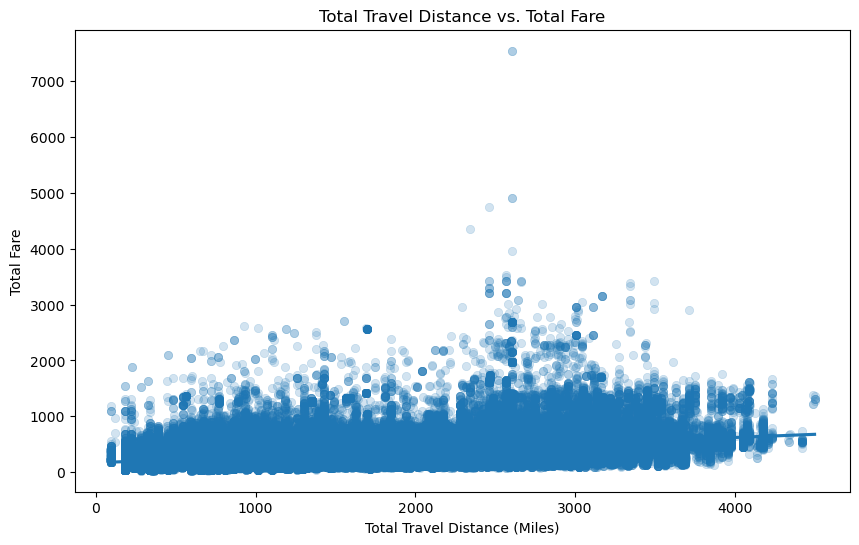

In [17]:
# Total Travel Distance vs. Total Fare

plt.figure(figsize=(10, 6))
sns.regplot(x='totalTravelDistance', y='totalFare', data=pdf, scatter_kws={'alpha': 0.2})
plt.title('Total Travel Distance vs. Total Fare')
plt.xlabel('Total Travel Distance (Miles)')
plt.ylabel('Total Fare')
plt.show()

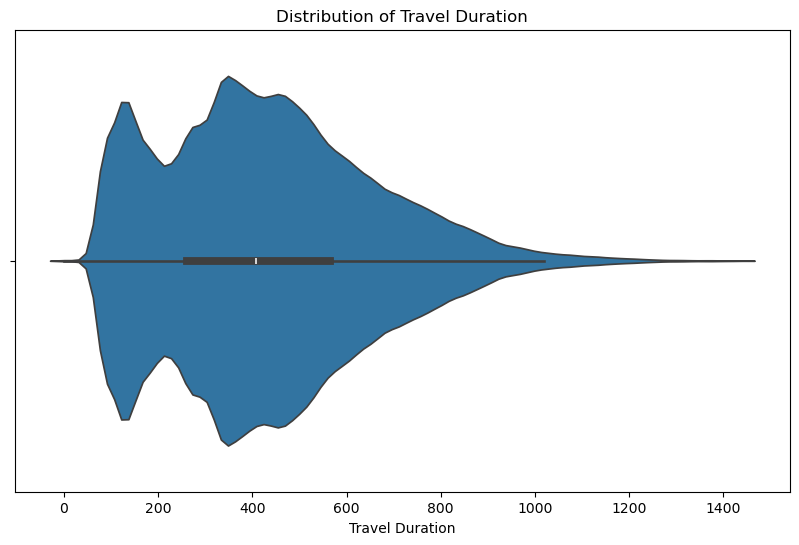

In [18]:
# Travel Duration Distribution

plt.figure(figsize=(10, 6))
sns.violinplot(x='travelDurationinMinutes', data=pdf)
plt.title('Distribution of Travel Duration')
plt.xlabel('Travel Duration')
plt.show()

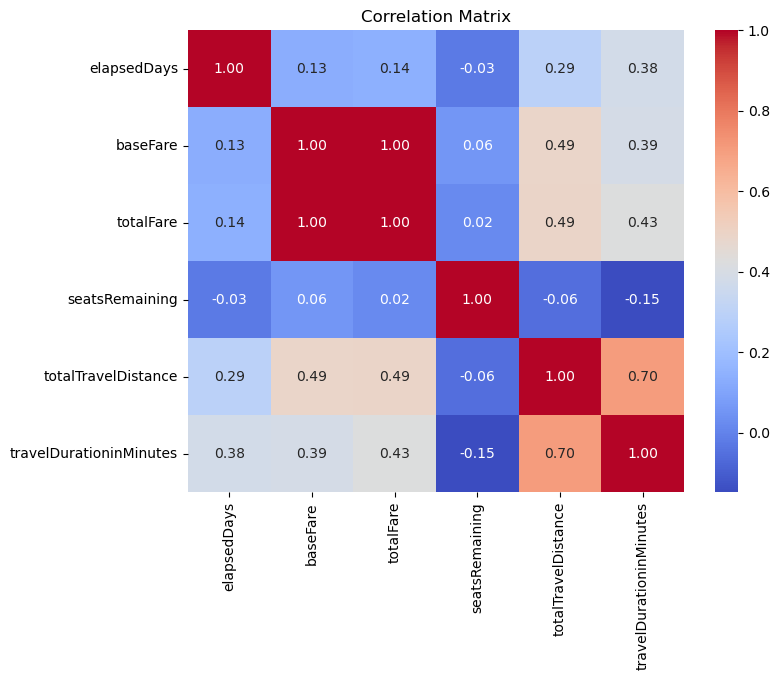

In [19]:
# Correlation Matrix

plt.figure(figsize=(8, 6))
correlation_matrix = pdf_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

# Visualizing Data: Checking for Outliers

In [20]:
#We will call describe before any changes
pdf_numeric.describe()

,elapsedDays,baseFare,totalFare,seatsRemaining,totalTravelDistance,travelDurationinMinutes
count,820287.000000,820287.000000,820287.000000,820287.000000,759376.000000,820287.000000
mean,0.150129,292.404809,340.113979,5.974861,1609.104243,427.577068
std,0.357208,182.779988,195.575685,2.881286,857.267682,224.058749
min,0.000000,0.010000,19.590000,0.000000,89.000000,0.000000
25%,0.000000,158.000000,196.600000,4.000000,876.000000,262.000000
50%,0.000000,260.470000,304.710000,7.000000,1467.000000,408.000000
75%,0.000000,398.140000,451.700000,9.000000,2415.000000,565.000000
max,2.000000,7000.000000,7548.600000,10.000000,4498.000000,1437.000000


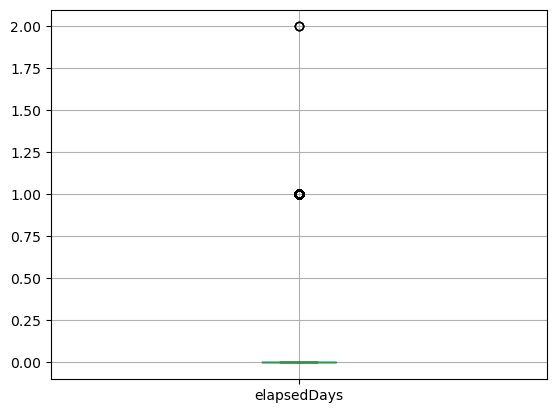

In [21]:
#elapsedDays, baseFare, totalFare, seatsRemaining, totalTravelDistance, travelDurationinMinutes

pdf_numeric.boxplot(column=['elapsedDays'])
plt.show()

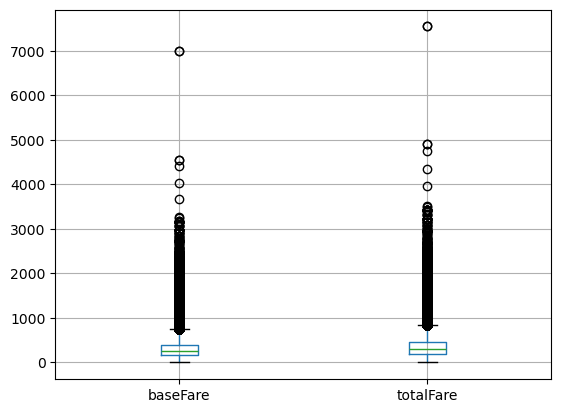

In [22]:
pdf_numeric.boxplot(column=['baseFare','totalFare'])
plt.show()

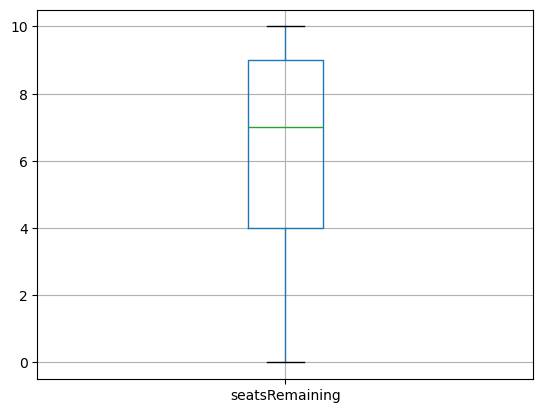

In [23]:
pdf_numeric.boxplot(column=['seatsRemaining'])
plt.show()

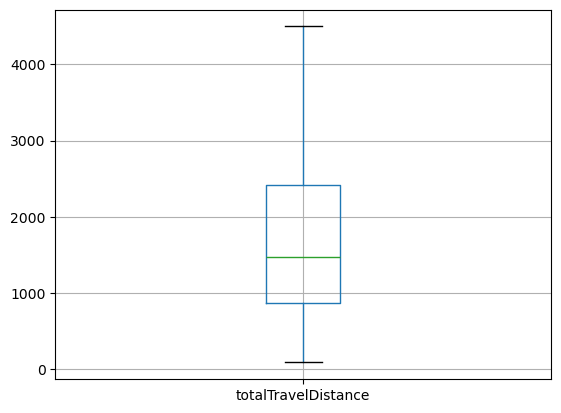

In [24]:
pdf_numeric.boxplot(column=['totalTravelDistance'])
plt.show()

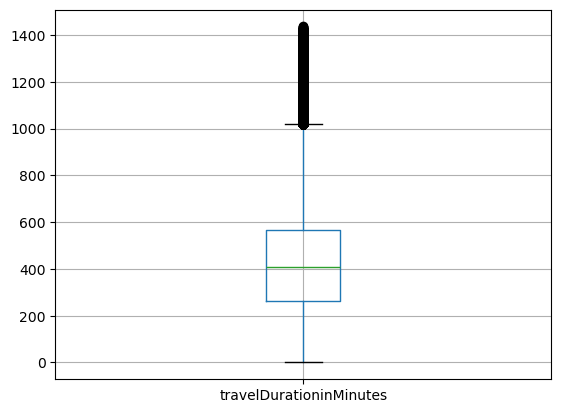

In [25]:
pdf_numeric.boxplot(column=['travelDurationinMinutes'])
plt.show()

# Other Descripters

In [26]:
# Convert both date columns to datetime instead of object so Pandas can find the min and max dates once we describe

pdf['searchDate'] = pd.to_datetime(pdf['searchDate'], format='%Y-%m-%d')
pdf['flightDate'] = pd.to_datetime(pdf['flightDate'], format='%Y-%m-%d')

In [27]:
pdf.describe()

,searchDate,flightDate,elapsedDays,baseFare,totalFare,seatsRemaining,totalTravelDistance,travelDurationinMinutes
count,820287,820287,820287.000000,820287.000000,820287.000000,820287.000000,759376.000000,820287.000000
mean,2022-07-13 19:37:55.329977088,2022-08-09 16:23:30.249827328,0.150129,292.404809,340.113979,5.974861,1609.104243,427.577068
min,2022-04-16 00:00:00,2022-04-17 00:00:00,0.000000,0.010000,19.590000,0.000000,89.000000,0.000000
25%,2022-06-04 00:00:00,2022-07-01 00:00:00,0.000000,158.000000,196.600000,4.000000,876.000000,262.000000
50%,2022-07-15 00:00:00,2022-08-14 00:00:00,0.000000,260.470000,304.710000,7.000000,1467.000000,408.000000
75%,2022-08-23 00:00:00,2022-09-18 00:00:00,0.000000,398.140000,451.700000,9.000000,2415.000000,565.000000
max,2022-10-05 00:00:00,2022-11-19 00:00:00,2.000000,7000.000000,7548.600000,10.000000,4498.000000,1437.000000
std,NaN,NaN,0.357208,182.779988,195.575685,2.881286,857.267682,224.058749


In [28]:
pdf.dtypes

legId                                        object
searchDate                           datetime64[ns]
flightDate                           datetime64[ns]
startingAirport                              object
destinationAirport                           object
fareBasisCode                                object
elapsedDays                                   int32
isBasicEconomy                                 bool
isRefundable                                   bool
isNonStop                                      bool
baseFare                                    float64
totalFare                                   float64
seatsRemaining                                int32
totalTravelDistance                         float64
segmentsDepartureTimeEpochSeconds            object
segmentsDepartureTimeRaw                     object
segmentsArrivalTimeEpochSeconds              object
segmentsArrivalTimeRaw                       object
segmentsArrivalAirportCode                   object
segmentsDepa